## Importing libraries, parameters.py

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = r'/home/yoda/Aron/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=/home/yoda/Aron/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully c

In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import numpy as np   # matrices, math
import time   # runtime measurement
import os    # file management
import pandas as pd   # data frames
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse_logf (control parameters: ['p_A', 'logf', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


## Ranges, settings

In [3]:
# Control parameter ranges
# make sure, it's only 2D

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1e-6*x for x in [150.0, 500.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble (list of species indexes)
    gases=  [[par.index['H2'], par.index['N2']]],
    # molar fractions of species in initial bubble (list of fractions for every gas)
    fractions = [[0.75, 0.25]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [500], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [20.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    P_v = [par.P_v],                    # vapour pressure [Pa]
    mu_L = [0.001, 0.053],                  # dynamic viscosity [Pa*s]
    # sound speed [m/s]
    c_L = [1923.0],
    # surfactant (surface tension modfier) [-]
    surfactant = [0.0171/par.sigma, 0.075/par.sigma],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [-1e5*x for x in [0.5, 4.0]], # pressure amplitude [Pa]
    logf = [3.9, 4.5], # frequency [Hz]
    n = [1.0]
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

examined_keys = []
for key in ranges:
    if len(ranges[key]) > 1:
        examined_keys.append(key)

print(f'The following control parameters will be examined: {examined_keys}')
if len(examined_keys) != 2:
    print(colored(f'Error, exactly 2 control parameters have to be examined', 'red'))
key1 = examined_keys[0]
key2 = examined_keys[1]

The following control parameters will be examined: ['R_E', 'mu_L', 'surfactant', 'p_A', 'logf']
Error, exactly 2 control parameters have to be examined


In [4]:
# Settings:
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
directory = r'D:\parameter_studies\2D_bruteforce\10000_Hz'   # appropiate 2D bruteforce parameter study
file_base_name = 'output_'

## Reading files, 2D contour plot
This is optional, you don't have to place a contour plot underneath the gadient descent visualization.
The bruteforce param study should be 2D with the same range as above, and uniform spacement.

In [113]:
# create a dataframe
all_data = pd.DataFrame()
num = 0

# iterate trough all files in directory (including subdirectories)
for (root, dirs, files) in os.walk(directory):
    for file in files:
        # ignore python rubish
        if 'ipynb_checkpoints' in root:
            continue
        # check if it's a CSV starting with file_base_name
        if file[-4:] != '.csv':
            continue
        if file[:len(file_base_name)] != file_base_name:
            continue

        # read file
        num += 1
        current_data = pd.read_csv(os.path.join(root, file))

        # Cast object-dtype columns with all-bool values to bool dtype
        for col in current_data.columns:
            if current_data[col].dtype == 'object' and all(current_data[col].dropna().map(lambda x: isinstance(x, bool))):
                current_data[col] = current_data[col].astype(bool)

                
        print(f'\t{file: <24} ({current_data.shape[0]: >4} rows)')
        all_data = pd.concat([all_data, current_data])

# locate successful simulations (or use all_data['success'] == True)
good_data = all_data.loc[
    (all_data['error_code'] % 100 <= 3) & ((all_data['error_code'] // 100) % 10 != 1) &
    (all_data['energy_efficiency'] > 0.0) & (all_data['energy_efficiency'] == all_data['energy_efficiency']) # positive not NaN
]

good_data = good_data.sort_values(['ID'], ascending=True)
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

	output_1.csv             (5001 rows)
	output_2.csv             (5001 rows)
	output_3.csv             (1248 rows)
Good data: 10520 rows ( 93.51 %)


In [114]:
# Check ranges vs good_data:
for key in ranges:
    llist = good_data[key].unique()
    llist.sort()
    if len(llist) > 1 and len(ranges[key]) < 2:
        print(colored(f'Error, {key} has {len(llist)} distinct values, but it should be constant {ranges[key][0]}', 'red'))
    if len(ranges[key]) > 1:
        if len(llist) < 2:
            print(colored(f'Error, {key} should have  values between {ranges[key][0]} and {ranges[key][1]}', 'red'))
        if abs(llist[0] - ranges[key][0]) > 1e-3 * ranges[key][0] + 1e-8:
            print(colored(f'Error, {key} has values between {llist[0]} and {llist[-1]}, but it should be between {ranges[key][0]} and {ranges[key][1]}', 'red'))
        if abs(llist[-1] - ranges[key][1]) > 1e-3 * ranges[key][1] + 1e-8:
            print(colored(f'Error, {key} has values between {llist[0]} and {llist[-1]}, but it should be between {ranges[key][0]} and {ranges[key][1]}', 'red'))

Error, p_A has values between -400000.0 and -50000.0, but it should be between -50000.0 and -400000.0
Error, p_A has values between -400000.0 and -50000.0, but it should be between -50000.0 and -400000.0


In [115]:
# list unique values:

output_list = list(good_data[to_optimize])
list1 = list(good_data[key1])
list2 = list(good_data[key2])
value_list1 = good_data[key1].unique()
value_list2 = good_data[key2].unique()
value_list1.sort()
value_list2.sort()
print(f'{key1}: from {value_list1[0]} to {value_list1[-1]} ({len(value_list1)} values)')
print(f'{key2}: from {value_list2[0]} to {value_list2[-1]} ({len(value_list2)} values)')

R_E: from 1e-06 to 0.0003 (150 values)
p_A: from -400000.0 to -50000.0 (75 values)


In [116]:
# Interpolate missing values:

vmin = min(output_list)
vmax = 100.0*vmin
combined = [(x, y) for x, y in zip(list1, list2)]
X, Y = np.meshgrid(value_list1, value_list2)
Z = np.zeros(X.shape)
fixed = 0
fixit = False

for i, x in enumerate(value_list1):
    for j, y in enumerate(value_list2):
        if (x, y) in combined:  # outliers
            index = combined.index((x, y))
            '''
            if (output_list[index-1] < vmax and 100*vmin < output_list[index] and 
                j != 0 and j != len(value_list2)-1 and
                output_list[index] > 10*output_list[index+1] and
                output_list[index] > 10*output_list[index-1]):

                output_list[index] = (output_list[index-1] + output_list[index+1]) / 2
                print(f'{index}: {key1}={x : .4e}, {key2}={y: .4e}, output={output_list[index]: .3f}')
            if (j == 0 or j == len(value_list2)-1) and (i != 0 and i != len(value_list1)-1 and i != len(value_list1)-2):
                if (output_list[index] > 10*output_list[index+len(value_list2)] and
                    output_list[index] > 10*output_list[index-len(value_list2)]):

                    output_list[index] = (output_list[index-len(value_list2)] + output_list[index+len(value_list2)]) / 2
                    print(f'{index}: {key1}={x : .4e}, {key2}={y: .4e}, output={output_list[index]: .3f}')'''
            Z[j, i] = output_list[index]
        else:   # missing values
            index = i * len(value_list2) + j
            extrapolation = (output_list[index-1] + output_list[index]) / 2
            combined = combined[:index] + [(x, y)] + combined[index:]
            output_list = output_list[:index] + [extrapolation] + output_list[index:]
            Z[j, i] = output_list[index]
            fixed += 1

print(f'{fixed} missing values fixed')

if True:
    pass
    Z = np.log10(Z)
    vmin = np.log10(vmin)
    vmax = 2.0*vmin

730 missing values fixed


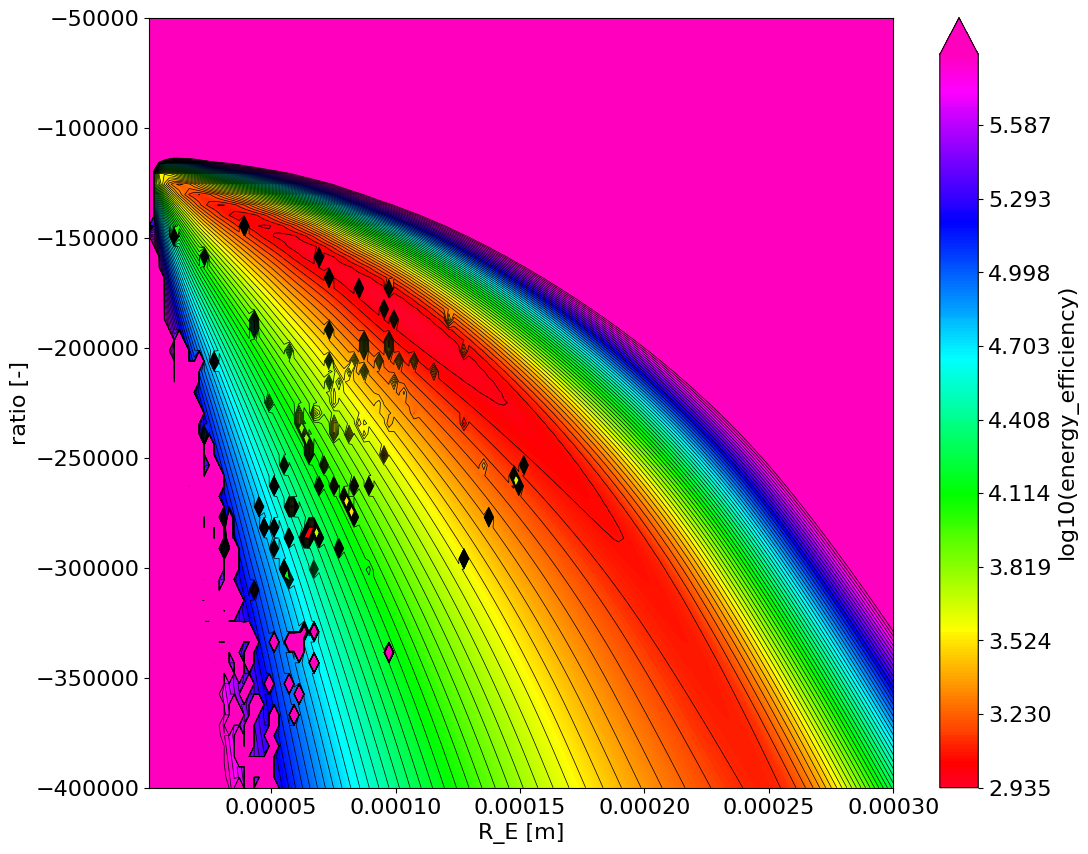

In [128]:
# Plot:

fig,ax=plt.subplots(1, 1, figsize=(12, 10))
levels = np.linspace(vmin, vmax, 250)
cp = ax.contourf(X, Y, Z, levels=levels, cmap='gist_rainbow', vmax=vmax, extend='max')
ax.contour(X, Y, Z, levels=np.linspace(vmin, vmax, 50), colors='black', linewidths=0.5)
fig.colorbar(cp, label='log10(energy_efficiency)') # Add a colorbar to a plot
#ax.set_title('log10(energy_efficiency)')
ax.set_xlabel('R_E [m]')
ax.set_ylabel('ratio [-]')
plt.show()

## Plot gradient descent search

In [133]:
# Generate random starting_point:

start_point = gd.rand_point(ranges, padding=0.1)   # random point in ranges
print(f'Starting point: ({key1}={start_point[key1]}, {key2}={start_point[key2]})')

# Calculate output in starting_point:
# A relatively small output is recommended

data, success = gd.evaluate(start_point, to_optimize, t_int=[0.0, 1.0], LSODA_timeout=10, Radau_timeout=0)
if not success:
    print(colored(f'Error, simulation failed', 'red'))
else:
    print(f'Output in starting point: {data[to_optimize]: .4f}')

Starting point: (R_E=0.000178738197250504, p_A=-263999.5832628441)
Output in starting point:  1113.5340


In [6]:
start_point = dict(
    ID = 1452,                                   # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E =  0.00033651,                           # bubble equilibrium radius [m]
    ratio =  1.00,                               # initial radius / equilibrium radius R_0/R_E [-]
    gases = [par.index['N2'], par.index['H2']],  # indexes of species in initial bubble (list of species indexes)
    fractions = [0.25, 0.75],                    # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb =  500.0,                             # ambient pressure [Pa]
    T_inf =  293.15,                             # ambient temperature [K]
  # Liquid parameters:
    alfa_M =  0.3500,                            # water accommodation coefficient [-]
    P_v =  4245.13,                              # vapour pressure [Pa]
    mu_L =  0.001502,                          # dynamic viscosity [Pa*s]
    c_L =  1923.00,                              # sound speed [m/s]
    surfactant =  1.5,                          # surfactant (surface tension modfier) [-]
  # Excitation parameters: (excitation_type = sin_impulse_logf)
    p_A = -299857.1336113528,                    # [Pa]
    logf = 4.063937804521581,                    # [-]
    n = 1.0,                                     # [-]
)

In [6]:
start_point_copy = gd.de.copy(start_point)

datas, last_bests, elapsed_time = gd.gradient_descent(
    ranges=ranges, path='', to_optimize=to_optimize, start_point=start_point_copy,
    step_limit=200, max_step_until_decay=50, first_step=0.002, decay=0.5, min_step=1e-4, delta=1e-5,
    verbose=True, t_int=np.array([0.0, 1.0]), LSODA_timeout=30, Radau_timeout=300
)

0. step; last_best= 3.51992e+01; absolute_best= 3.51992e+01; step_size= 0.00300
	point   =(R_E= 3.365100e-04; mu_L= 1.002000e-03; surfactant= 1.500000e+00; p_A=-2.998571e+05; logf= 4.063938e+00; )
	decayed: step_size= 0.0015; next_output=39.52739525978999
	output  =39.226031235815704; success=True
	gradient=(R_E= 0.2178; mu_L= 0.6883; surfactant= 0.0107; p_A= 0.3671; logf= 0.5864; )
	change  =(R_E=-1.143396e-07; mu_L=-5.369022e-05; surfactant=-1.285418e-05; p_A=-1.927366e+02; logf=-5.277657e-04; )
1. step; last_best= 3.92239e+01; absolute_best= 3.51992e+01; step_size= 0.00150
	point   =(R_E= 3.363957e-04; mu_L= 1.005200e-03; surfactant= 1.042020e+00; p_A=-3.000499e+05; logf= 4.063410e+00; )
	output  =38.82837001082385; success=True
	gradient=(R_E=-0.4714; mu_L= 0.2354; surfactant=-0.0493; p_A=-0.4464; logf=-0.7216; )
	change  =(R_E= 2.474840e-07; mu_L=-1.836461e-05; surfactant= 5.953444e-05; p_A= 2.343443e+02; logf= 6.494172e-04; )
2. step; last_best= 3.88264e+01; absolute_best= 3.5199

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


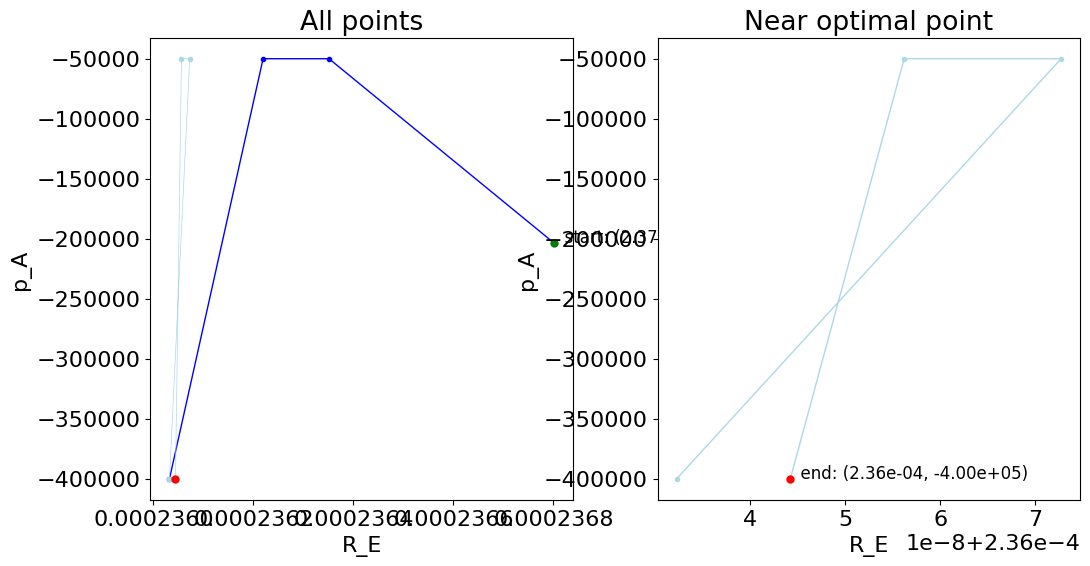

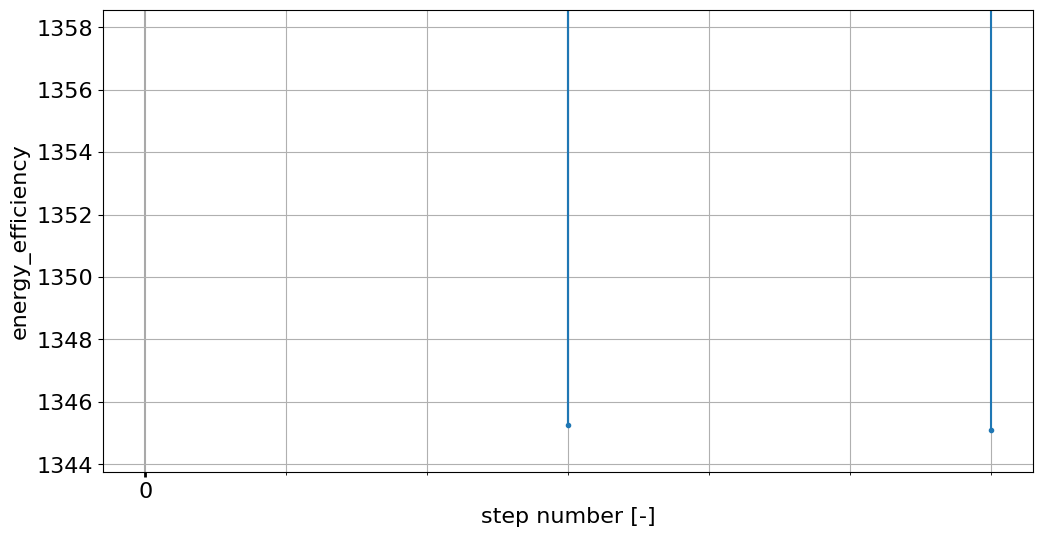

last output:  1345.11


In [106]:
all_central_points = []
central_outputs = []
for points in datas:
    outputs = [data[to_optimize] for data in points]
    central_outputs.append(outputs[0])
    #central_outputs.append(min(outputs))
    all_central_points.append(points[0])
value1 = [data[key1] for data in all_central_points]
value2 = [data[key2] for data in all_central_points]
start = len(all_central_points) // 2
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(value1[:start+1], value2[:start+1], '.-', color='blue', linewidth=1, zorder=1)
ax[0].plot(value1[start:], value2[start:], '.-', color='lightblue', linewidth=0.5, zorder=1)
ax[1].plot(value1[start:], value2[start:], '.-', color='lightblue', linewidth=1, zorder=1)
ax[0].scatter([value1[0]], [value2[0]], color='green', zorder=2, s=25)   # start point
ax[0].scatter([value1[-1]], [value2[-1]], color='red', zorder=2, s=25)   # optimal point
ax[1].scatter([value1[-1]], [value2[-1]], color='red', zorder=2, s=25)   # optimal point
ax[0].text(value1[0], value2[0], f'  start: ({value1[0]:.2e}, {value2[0]:.2e})', fontsize=12)
ax[1].text(value1[-1], value2[-1], f'  end: ({value1[-1]:.2e}, {value2[-1]:.2e})', fontsize=12)
ax[0].set_title('All points')
ax[1].set_title('Near optimal point')
ax[0].set_xlabel(key1)
ax[0].set_ylabel(key2)
ax[1].set_xlabel(key1)
ax[1].set_ylabel(key2)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(len(central_outputs[:])), central_outputs[:], '.-')
ax.set_ylim([0.999*min(central_outputs), 1.01*min(central_outputs)])
ax.set_xticks(range(0, len(central_outputs[:]), 10), minor=False)
ax.set_xticks(range(len(central_outputs[:])), minor=True)
ax.tick_params(which='major', axis='x', width=2, grid_color='darkgrey', grid_linewidth=1.5)
ax.set_xlabel('step number [-]')
ax.set_ylabel(to_optimize)
ax.grid(which='both')
#plt.yscale('log')
plt.show()
print(f'last output: {central_outputs[-1]: .2f}')

In [122]:
vmin, vmax

(2.935041576090755, 5.87008315218151)

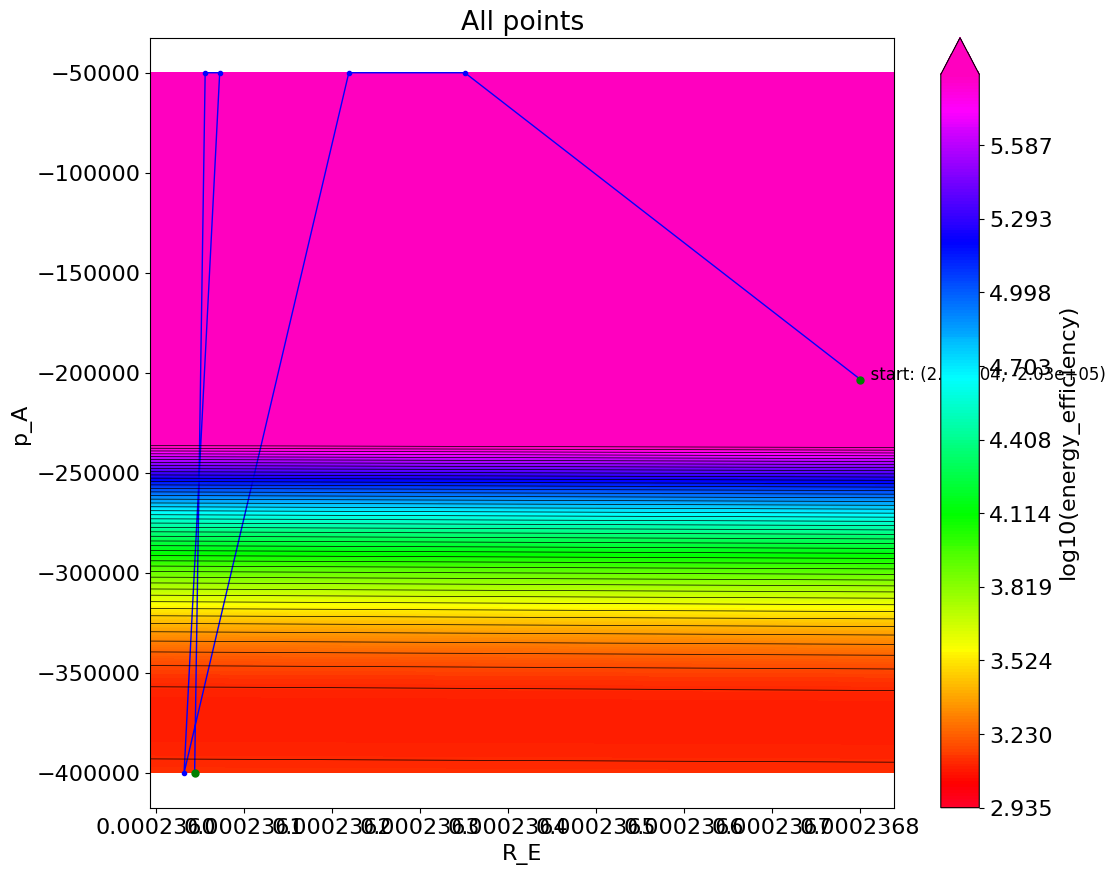

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
levels = np.linspace(vmin, vmax, 250)
maxi = np.log10(max(central_outputs))
cp = ax.contourf(X, Y, Z, levels=levels, cmap='gist_rainbow', vmax=vmax, extend='max')
ax.contour(X, Y, Z, levels=np.linspace(vmin, vmax, 50), colors='black', linewidths=0.5)
fig.colorbar(cp, label='log10(energy_efficiency)') # Add a colorbar to a plot

ax.plot(value1[:], value2[:], '.-', color='blue', linewidth=1, zorder=1)
ax.scatter([value1[0]], [value2[0]], color='green', zorder=2, s=25)   # start point
ax.scatter([value1[-1]], [value2[-1]], color='green', zorder=2, s=25)   # optimal point
ax.text(value1[0], value2[0], f'  start: ({value1[0]:.2e}, {value2[0]:.2e})', fontsize=12)
ax.set_title('All points')
ax.set_xlabel(key1)
ax.set_ylabel(key2)

range1 = max(value1) - min(value1)
range2 = max(value2) - min(value2)
range1 = [min(value1) - 0.05*range1, max(value1) + 0.05*range1]
range2 = [min(value2) - 0.05*range2, max(value2) + 0.05*range2]
ax.set_xlim(range1)
ax.set_ylim(range2)

plt.show()